In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, hamming_loss #mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error,
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import shap

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = '/content/Cleaned_Medical_Data.csv'
medical_data = pd.read_csv(data_path)

x = medical_data.iloc[:, :16]
y = medical_data.iloc[:, 16:]

x_cols = x.columns.values
y_cols = y.columns.values
print(f"X: {x_cols}")
print(f"Y: {y_cols}")

# Function to classify values
def classify(value, mean, std):
    if value < mean - std:
        return 0 # low
    elif mean - std <= value <= mean + std:
        return 1 # medium
    else:
        return 2 # high

y_classes = pd.DataFrame()

# Add classification columns for each original column
y_classes['mbi_ex_classes'] = y[y_cols[0]].apply(lambda x: classify(x, y[y_cols[0]].mean(), y[y_cols[0]].std()))
y_classes['mbi_cy_classes'] = y[y_cols[1]].apply(lambda x: classify(x, y[y_cols[1]].mean(), y[y_cols[1]].std()))
y_classes['mbi_ea_classes'] = y[y_cols[2]].apply(lambda x: classify(x, y[y_cols[2]].mean(), y[y_cols[2]].std()))

print(y_cols[0])
print(y[y_cols[0]].mean(), y[y_cols[0]].std())
print(y_cols[1])
print(y[y_cols[1]].mean(), y[y_cols[1]].std())
print(y_cols[2])
print(y[y_cols[2]].mean(), y[y_cols[2]].std())

print(y_classes)
y_classes_cols = y_classes.columns.values

x_train, x_test, y_train, y_test = train_test_split(x, y_classes, test_size=0.2, random_state=42)

X: ['age' 'year' 'sex' 'glang' 'part' 'job' 'stud_h' 'health' 'psyt' 'jspe'
 'qcae_cog' 'qcae_aff' 'amsp' 'erec_mean' 'cesd' 'stai_t']
Y: ['mbi_ex' 'mbi_cy' 'mbi_ea']
mbi_ex
16.806024096385542 5.134825146752114
mbi_cy
10.006024096385541 4.465788715720864
mbi_ea
24.2855421686747 4.563626912702248
     mbi_ex_classes  mbi_cy_classes  mbi_ea_classes
0                 1               1               1
1                 2               1               1
2                 1               1               1
3                 2               1               1
4                 1               2               0
..              ...             ...             ...
825               2               0               2
826               1               0               1
827               1               1               2
828               2               2               0
829               0               1               2

[830 rows x 3 columns]


## Scaled

In [ ]:
# mean of 0 and std of 1 data transformation
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

acc_lr_scaled = []
acc_rf_scaled = []
for col in y_classes_cols:
    print(f"=====  {col}  ======")
    # Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(x_train_scaled, y_train[col])
    y_pred_log = log_reg.predict(x_test_scaled)

    # Random Forest Classifier
    rf_clf_scale = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf_scale.fit(x_train_scaled, y_train[col])
    y_pred_rf = rf_clf_scale.predict(x_test_scaled)

    # Evaluation
    print("Logistic Regression Evaluation:")
    print(classification_report(y_test[col], y_pred_log))
    acc = accuracy_score(y_test[col], y_pred_log)
    acc_lr_scaled.append(acc)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test[col], y_pred_log))

    print("\nRandom Forest Evaluation:")
    print(classification_report(y_test[col], y_pred_rf))
    acc = accuracy_score(y_test[col], y_pred_rf)
    acc_rf_scaled.append(acc)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test[col], y_pred_rf))

=====  mbi_ex_classes  ======
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.40      0.54        25
           1       0.69      0.93      0.79       101
           2       0.71      0.30      0.42        40

    accuracy                           0.70       166
   macro avg       0.74      0.54      0.58       166
weighted avg       0.71      0.70      0.66       166

Accuracy: 0.6987951807228916
Confusion Matrix:
 [[10 15  0]
 [ 2 94  5]
 [ 0 28 12]]

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.44      0.56        25
           1       0.69      0.91      0.78       101
           2       0.61      0.28      0.38        40

    accuracy                           0.69       166
   macro avg       0.69      0.54      0.58       166
weighted avg       0.68      0.69      0.65       166

Accuracy: 0.6867469879518072
Confusion Matrix:
 [[11 13  1]
 [ 3

=====  mbi_ex_classes  ======
45 52 0 14
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.40      0.54        25
           1       0.69      0.93      0.79       101
           2       0.71      0.30      0.42        40

    accuracy                           0.70       166
   macro avg       0.74      0.54      0.58       166
weighted avg       0.71      0.70      0.66       166

Confusion Matrix:
 [[10 15  0]
 [ 2 94  5]
 [ 0 28 12]]

SHAP Explainability for Logistic Regression:
True positive


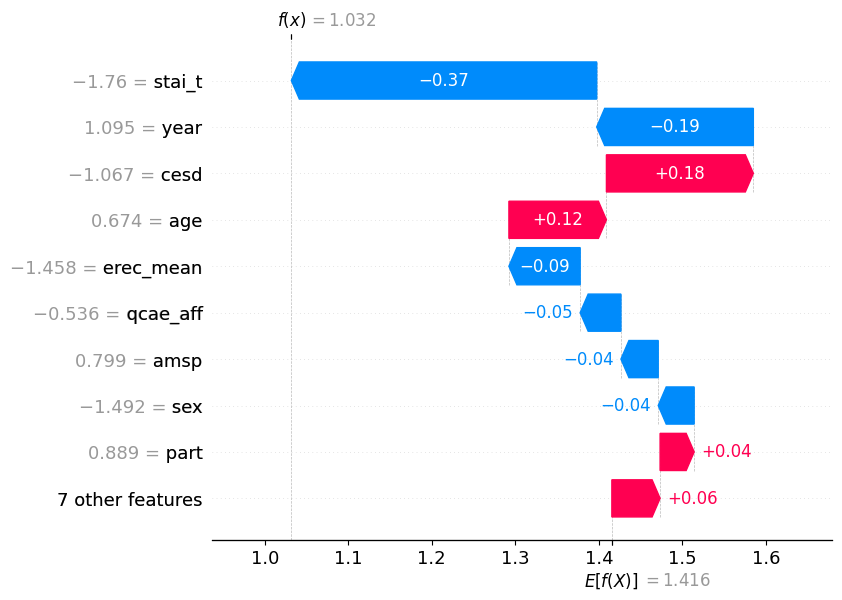

False positive


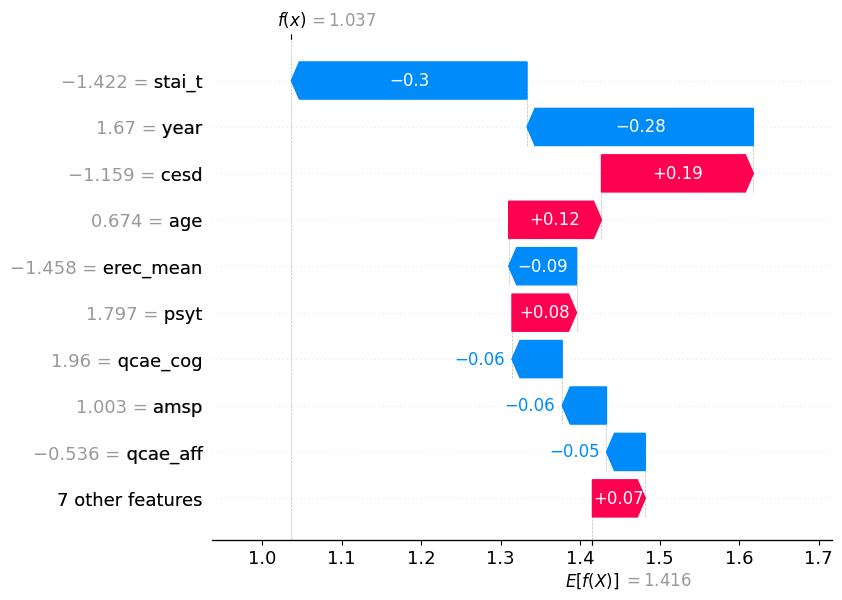

True negative


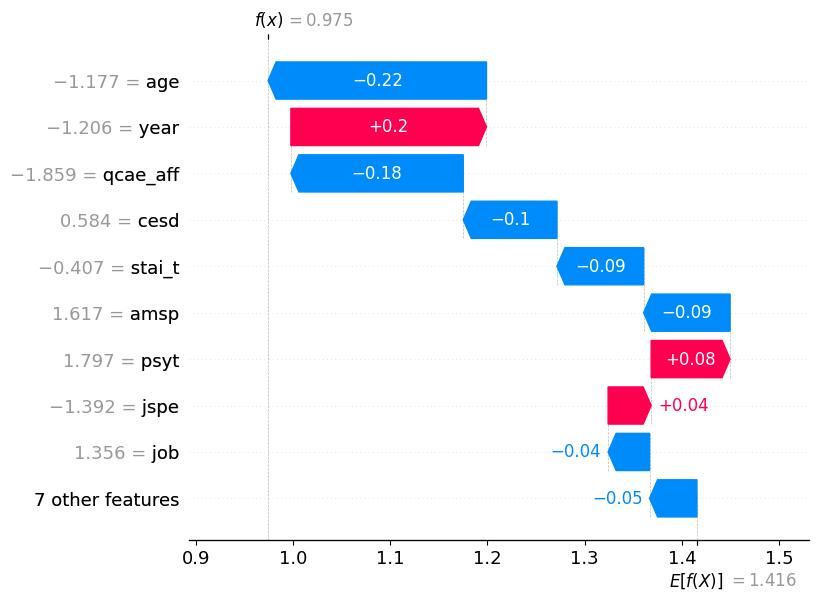

False negative


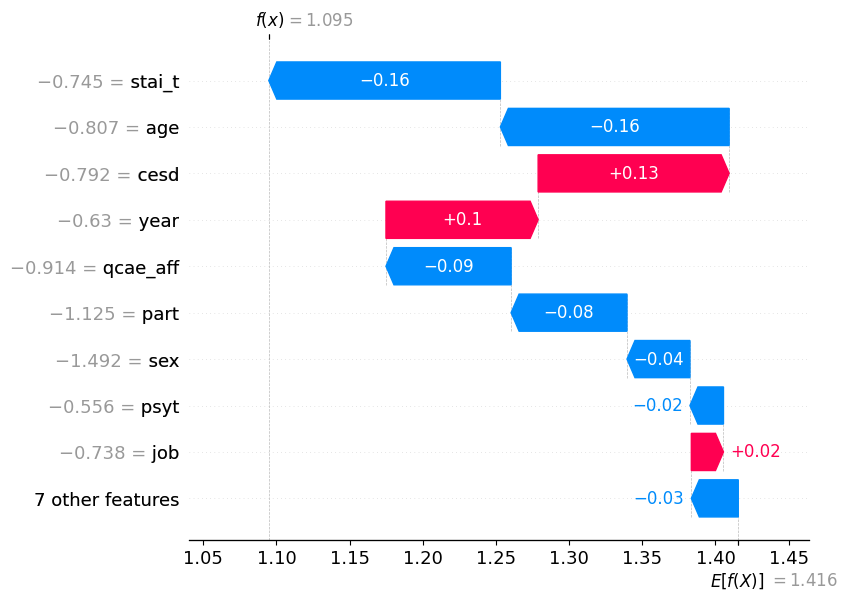

=====  mbi_cy_classes  ======
25 81 0 11
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.67      0.12      0.21        32
           1       0.64      0.95      0.77       100
           2       0.67      0.24      0.35        34

    accuracy                           0.64       166
   macro avg       0.66      0.44      0.44       166
weighted avg       0.65      0.64      0.57       166

Confusion Matrix:
 [[ 4 28  0]
 [ 1 95  4]
 [ 1 25  8]]

SHAP Explainability for Logistic Regression:
True positive


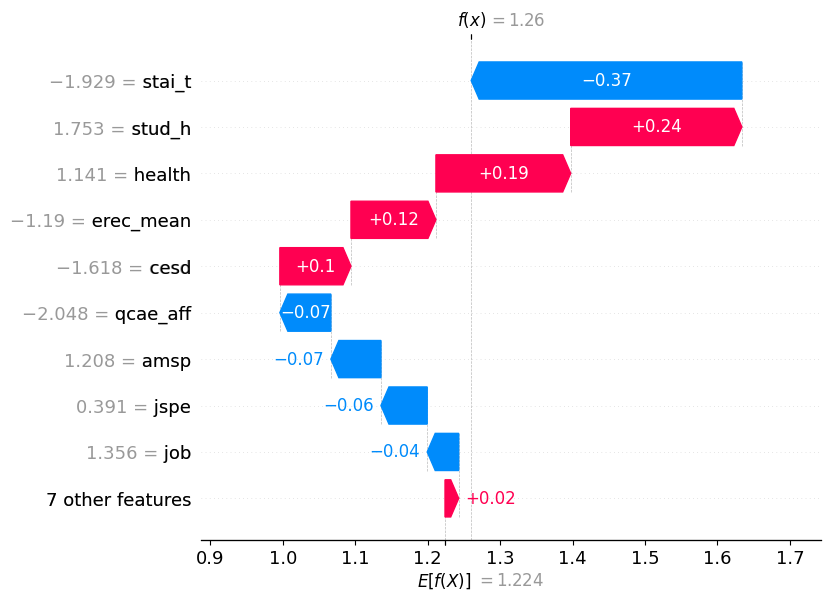

False positive


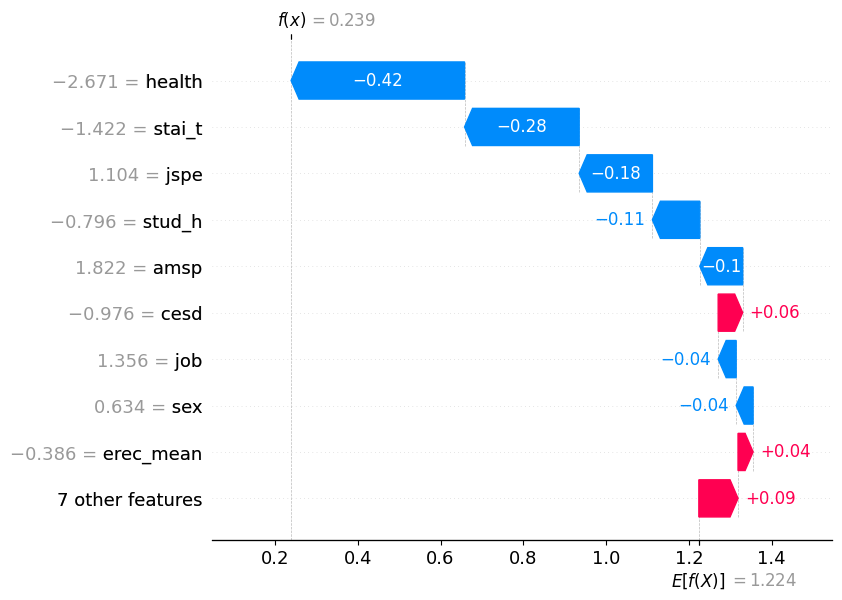

True negative


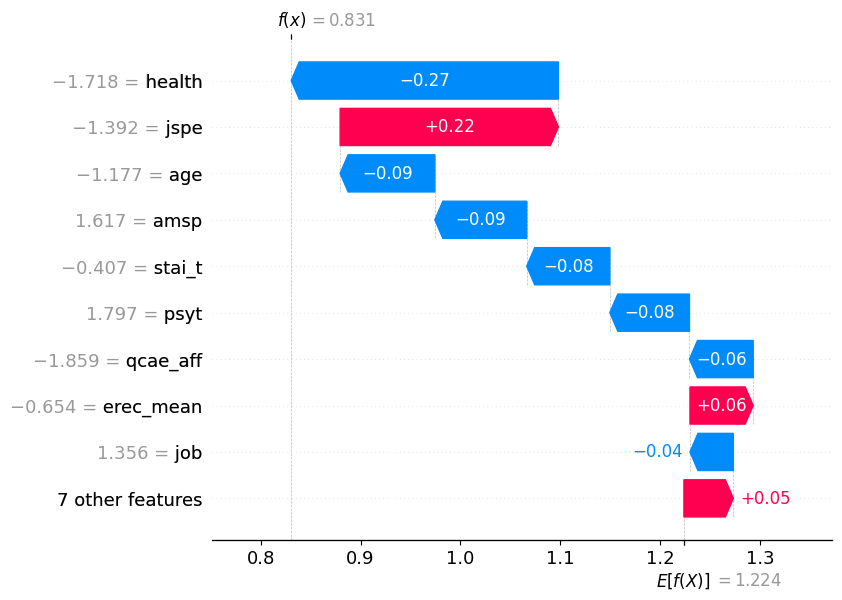

False negative


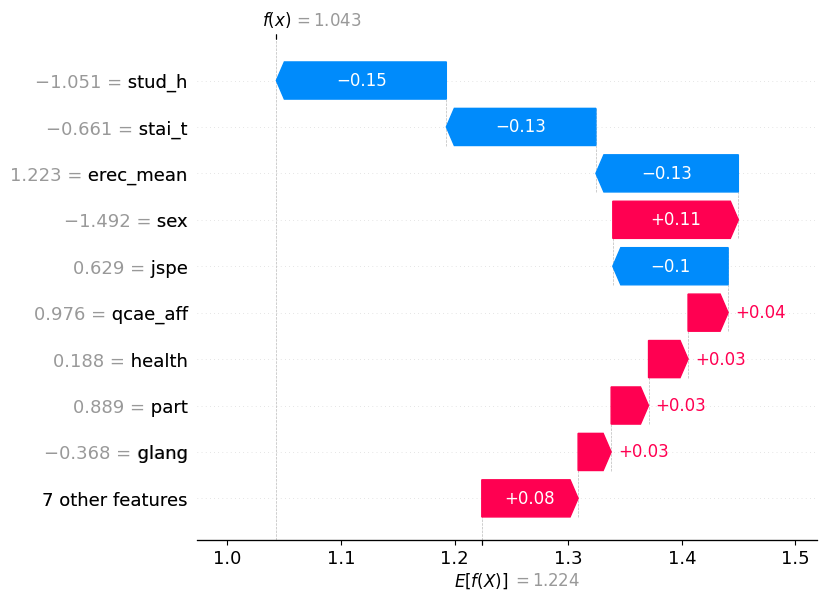

=====  mbi_ea_classes  ======
35 38 0 5
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.62      0.18      0.28        28
           1       0.70      0.94      0.80       108
           2       0.75      0.30      0.43        30

    accuracy                           0.70       166
   macro avg       0.69      0.47      0.50       166
weighted avg       0.70      0.70      0.65       166

Confusion Matrix:
 [[  5  23   0]
 [  3 102   3]
 [  0  21   9]]

SHAP Explainability for Logistic Regression:
True positive


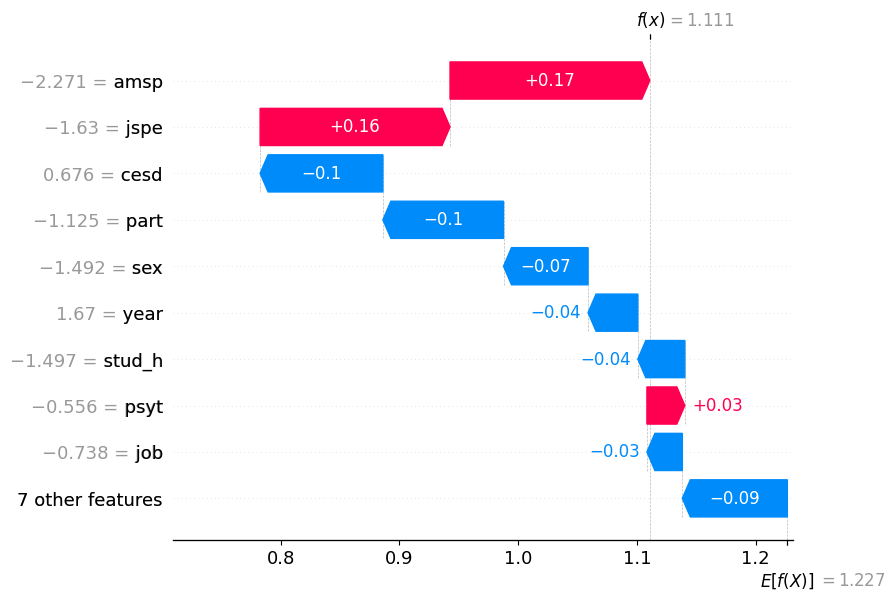

False positive


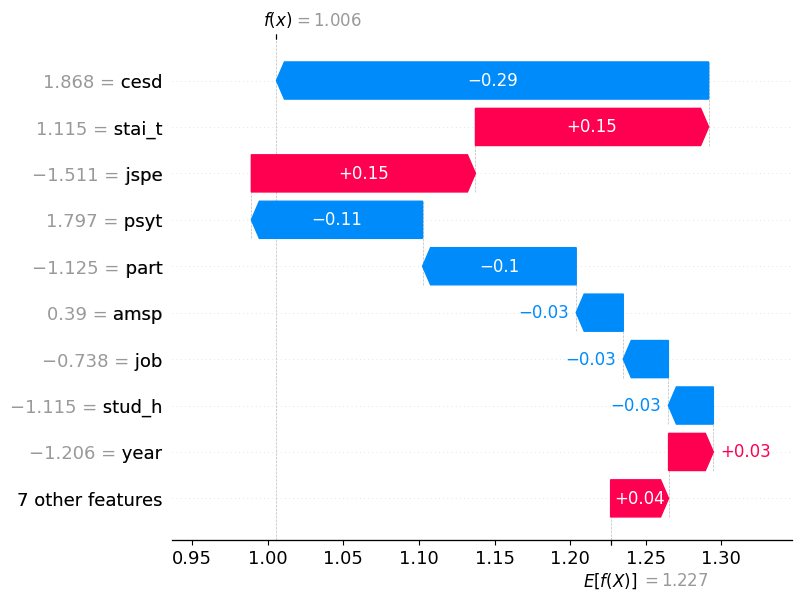

True negative


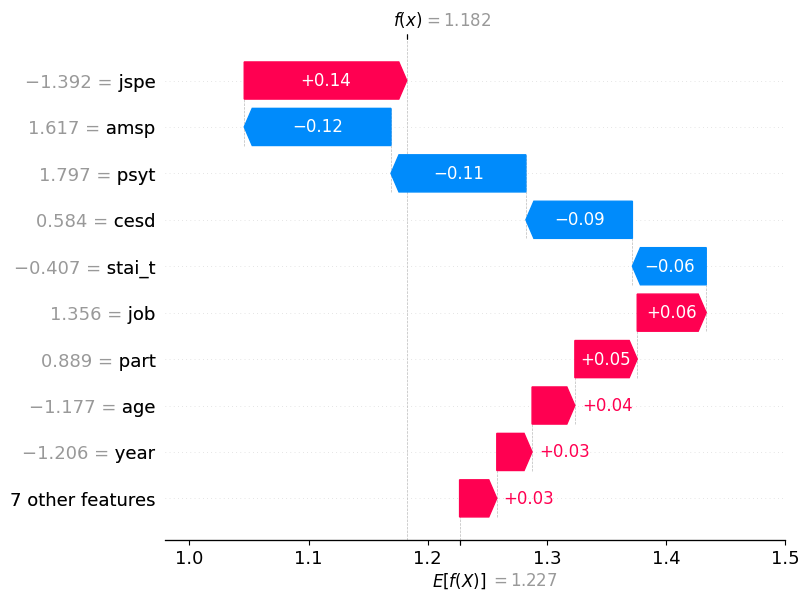

False negative


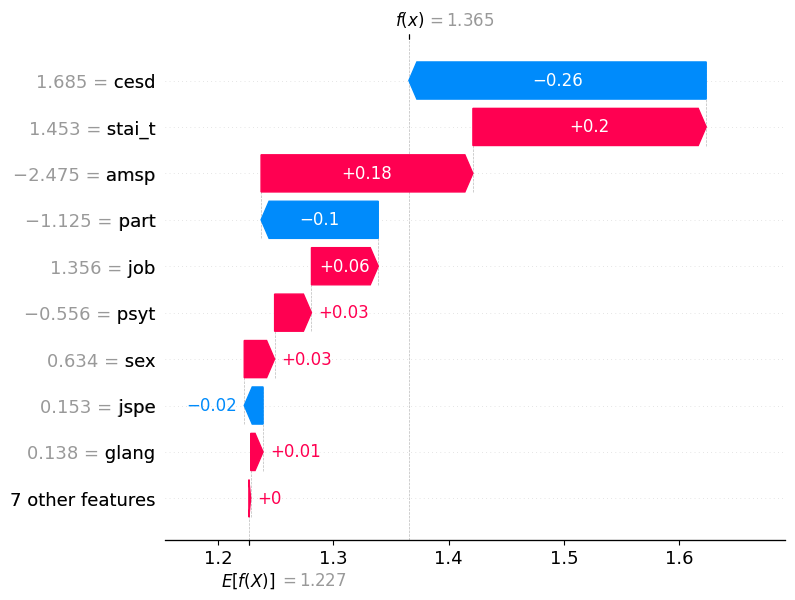

In [ ]:
# Initialize lists to store SHAP values for each classifier
shap_values_lr = {}

x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_cols)

for col in y_classes_cols:
    print(f"=====  {col}  ======")
    # Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(x_train_scaled, y_train[col])
    y_pred_log = log_reg.predict(x_test_scaled)

    y_test_1 = y_test[col].reset_index(drop=True)  # Reset index for easier comparison

    # Conditions
    tp_index = y_test_1[(y_test_1 == 0) & (y_pred_log == 0)].index[0]
    fp_index = y_test_1[(y_test_1 != 0) & (y_pred_log == 0)].index[0]
    tn_index = y_test_1[(y_test_1 != 0) & (y_pred_log != 0)].index[0]
    fn_index = y_test_1[(y_test_1 == 0) & (y_pred_log != 0)].index[0]
    print(f"{tp_index} {fp_index} {tn_index} {fn_index}")

    # Evaluation
    print("Logistic Regression Evaluation:")
    print(classification_report(y_test[col], y_pred_log))
    acc_lr_scaled.append(accuracy_score(y_test[col], y_pred_log))
    print("Confusion Matrix:\n", confusion_matrix(y_test[col], y_pred_log))

    # Explainability with SHAP for Logistic Regression
    print("\nSHAP Explainability for Logistic Regression:")
    explainer_lr = shap.LinearExplainer(log_reg, x_train_scaled)
    shap_values_lr[col] = explainer_lr(x_test_scaled)

    print("True positive")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_lr[col][tp_index].values[:, 1],
            base_values=shap_values_lr[col][tp_index].base_values[1],
            data=x_test_scaled_df.iloc[tp_index],
            feature_names=x_cols
        )
    )

    # False Positive (FP)
    print("False positive")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_lr[col][fp_index].values[:, 1],
            base_values=shap_values_lr[col][fp_index].base_values[1],
            data=x_test_scaled_df.iloc[fp_index],
            feature_names=x_cols
        )
    )

    # True Negative (TN)
    print("True negative")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_lr[col][tn_index].values[:, 1],
            base_values=shap_values_lr[col][tn_index].base_values[1],
            data=x_test_scaled_df.iloc[tn_index],
            feature_names=x_cols
        )
    )

    # False Negative (FN)
    print("False negative")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_lr[col][fn_index].values[:, 1],
            base_values=shap_values_lr[col][fn_index].base_values[1],
            data=x_test_scaled_df.iloc[fn_index],
            feature_names=x_cols
        )
    )


=====  mbi_ex_classes  ======

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.44      0.56        25
           1       0.69      0.91      0.78       101
           2       0.61      0.28      0.38        40

    accuracy                           0.69       166
   macro avg       0.69      0.54      0.58       166
weighted avg       0.68      0.69      0.65       166

Confusion Matrix:
 [[11 13  1]
 [ 3 92  6]
 [ 0 29 11]]

SHAP Explainability for Random Forest:
True positive


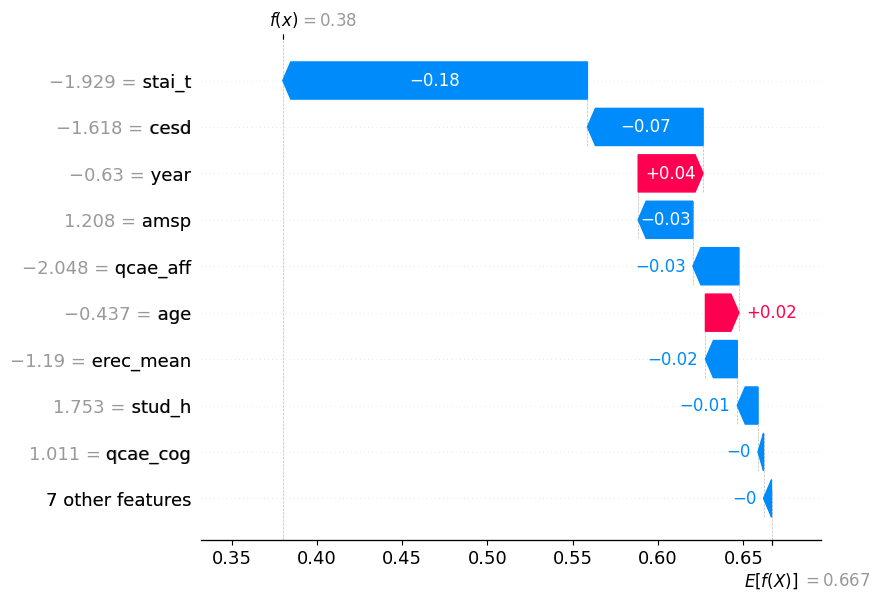

False positive


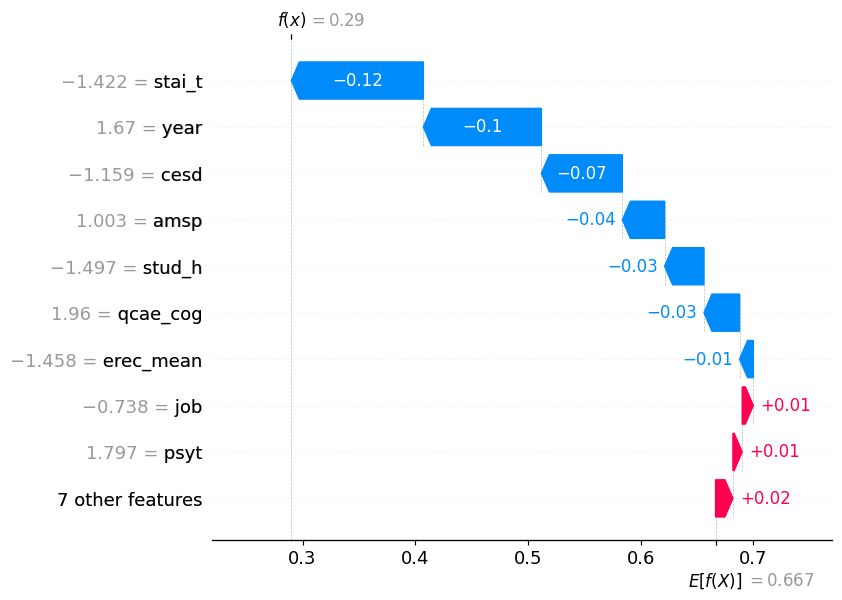

True negative


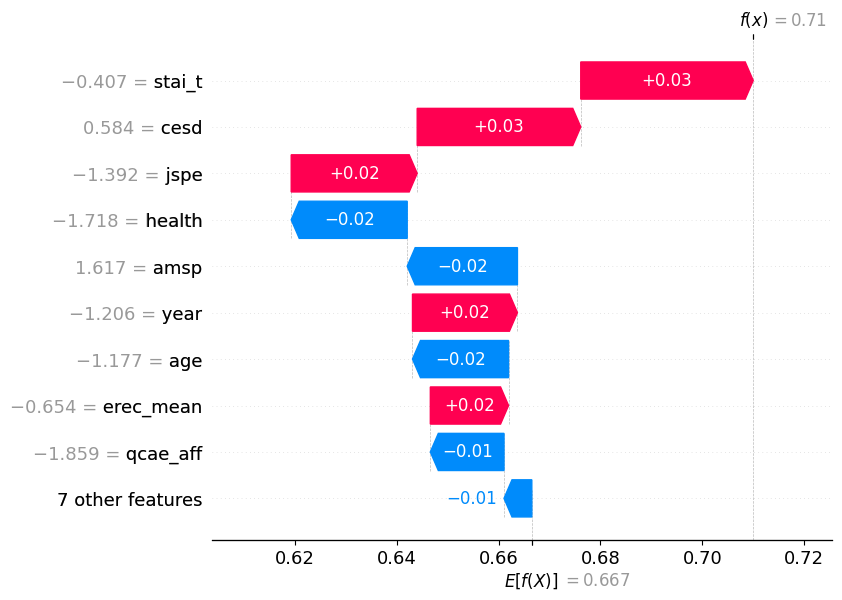

False negative


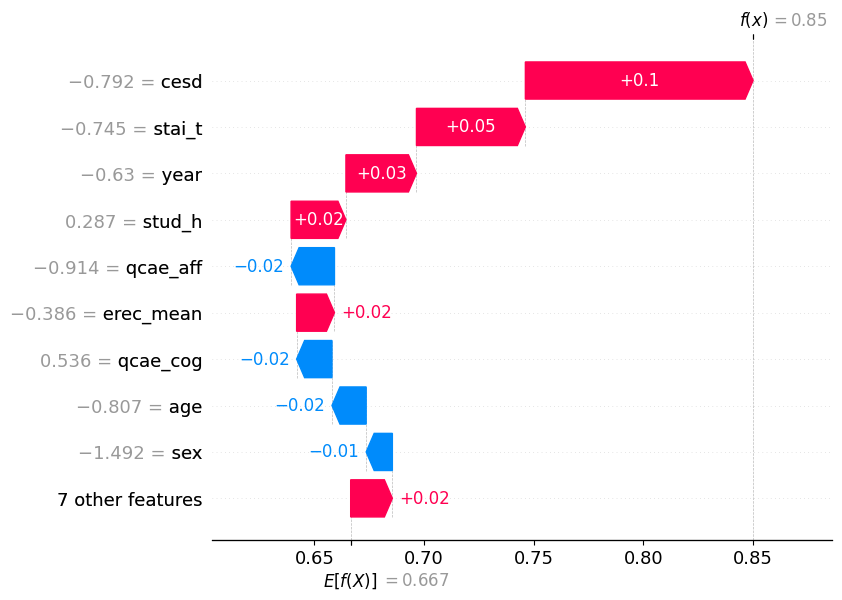

=====  mbi_cy_classes  ======

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.29      0.06      0.10        32
           1       0.62      0.94      0.75       100
           2       0.57      0.12      0.20        34

    accuracy                           0.60       166
   macro avg       0.49      0.37      0.35       166
weighted avg       0.54      0.60      0.51       166

Confusion Matrix:
 [[ 2 30  0]
 [ 3 94  3]
 [ 2 28  4]]

SHAP Explainability for Random Forest:
True positive


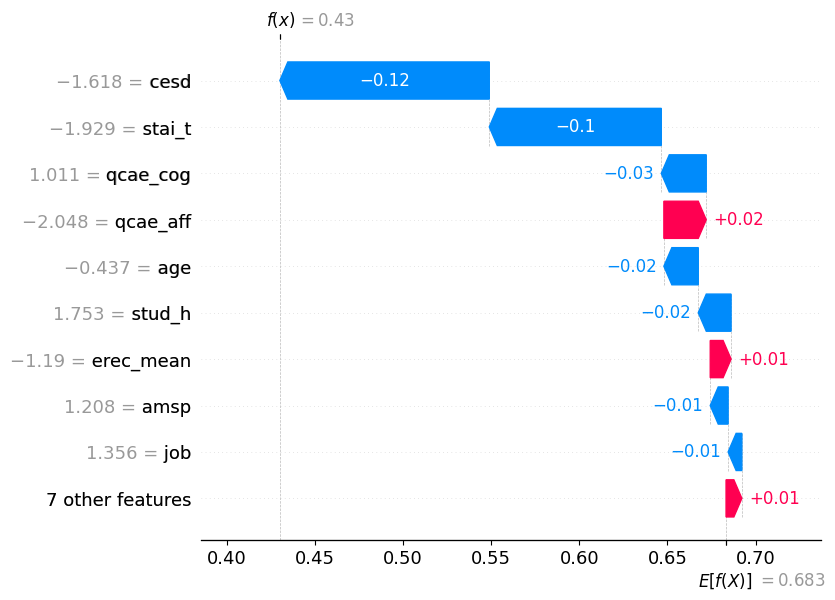

False positive


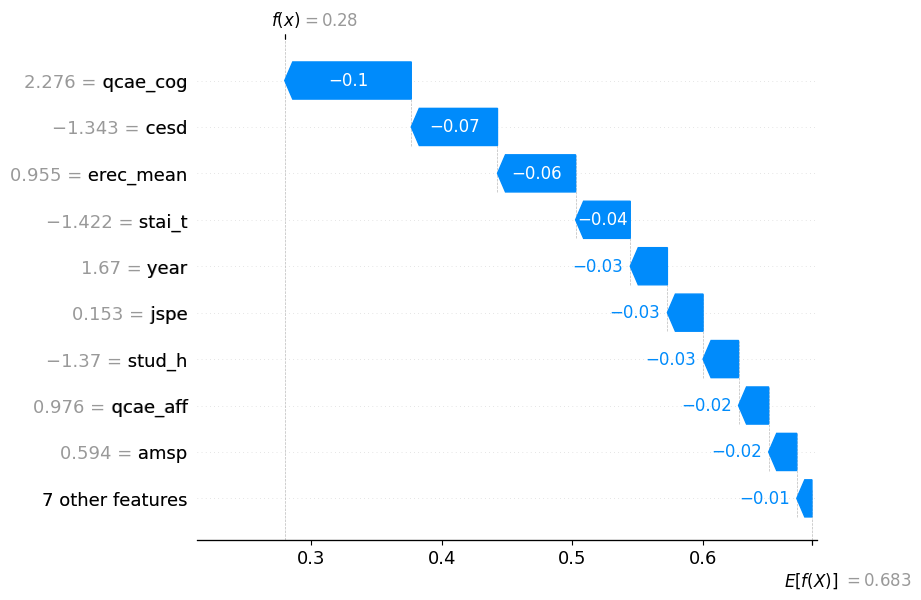

True negative


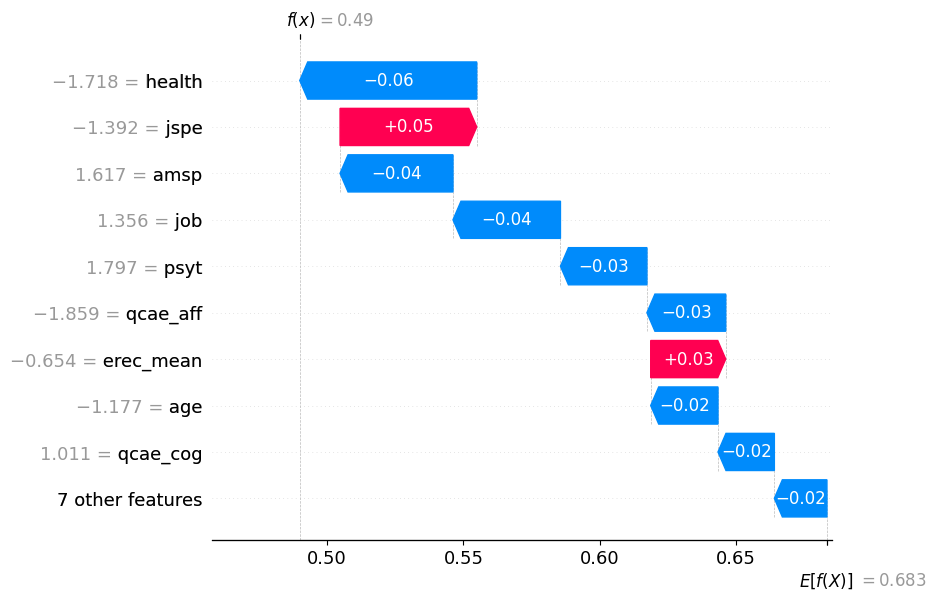

False negative


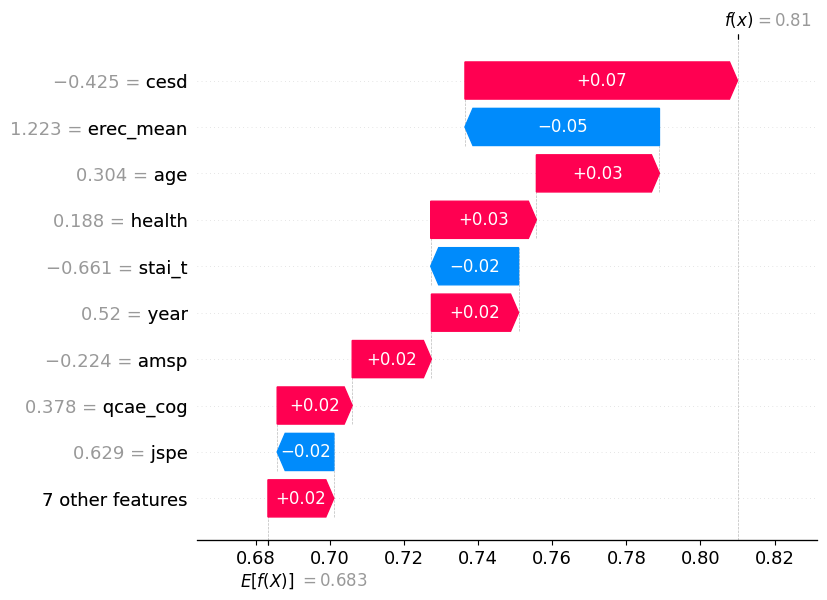

=====  mbi_ea_classes  ======

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.50      0.11      0.18        28
           1       0.68      0.91      0.78       108
           2       0.56      0.30      0.39        30

    accuracy                           0.66       166
   macro avg       0.58      0.44      0.45       166
weighted avg       0.63      0.66      0.61       166

Confusion Matrix:
 [[ 3 25  0]
 [ 3 98  7]
 [ 0 21  9]]

SHAP Explainability for Random Forest:
True positive


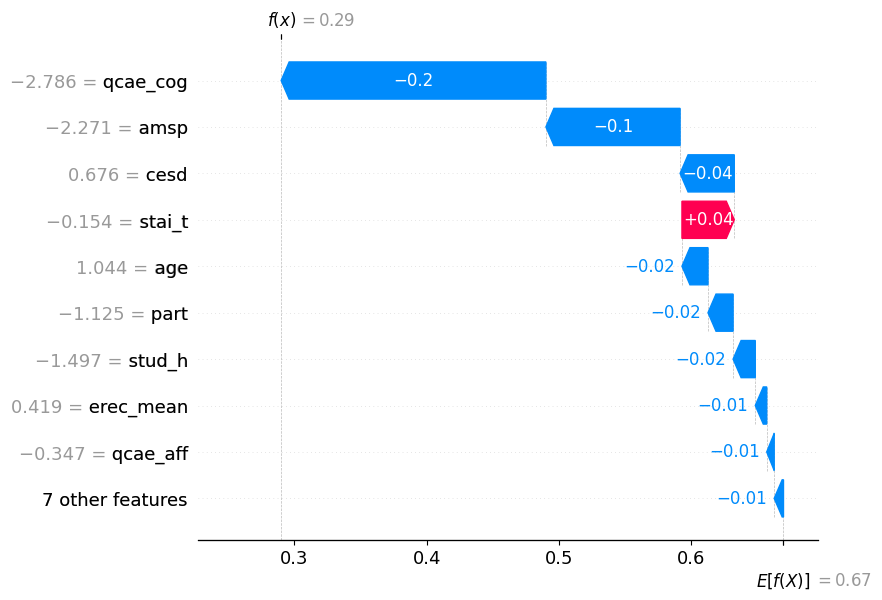

False positive


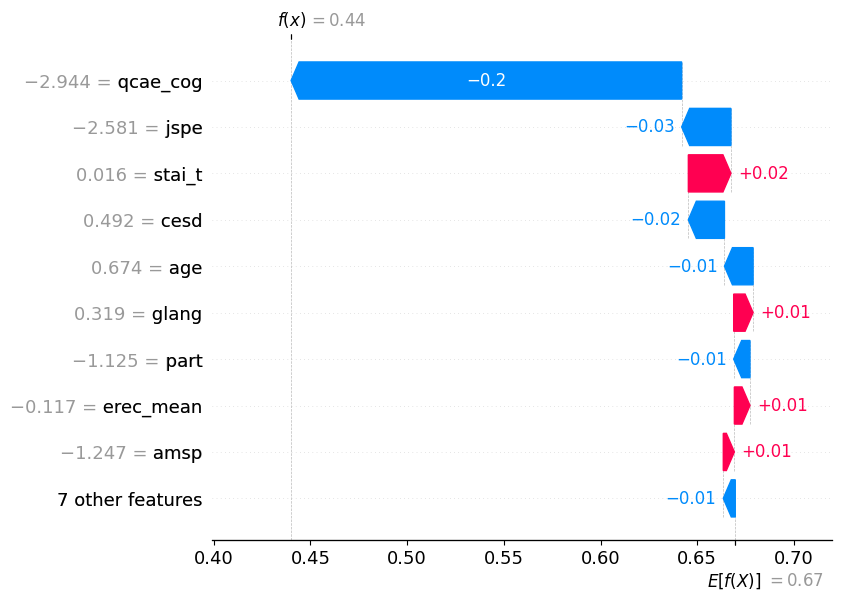

True negative


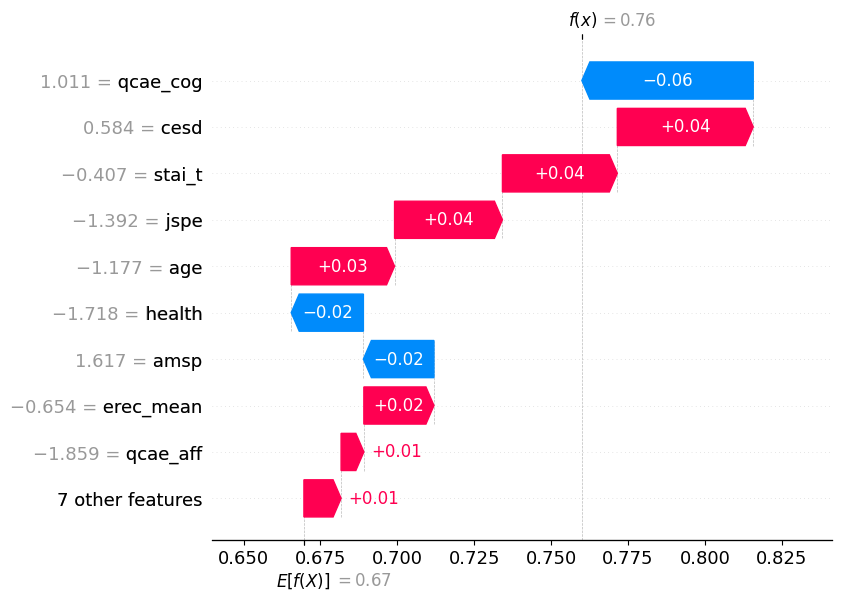

False negative


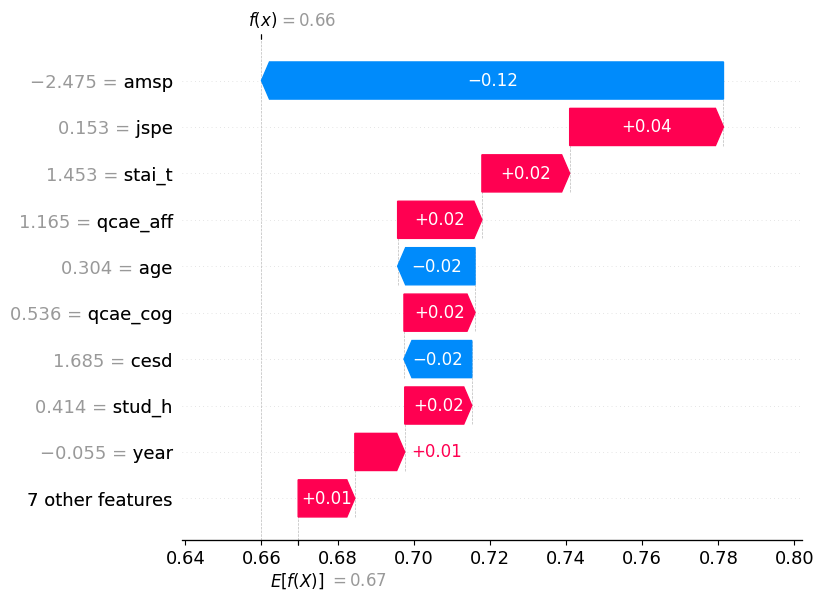

In [ ]:
# Initialize lists to store SHAP values for each classifier
shap_values_rf = {}

for col in y_classes_cols:
    print(f"=====  {col}  ======")
    # Random Forest Classifier
    rf_clf_scale = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf_scale.fit(x_train_scaled, y_train[col])
    y_pred_rf = rf_clf_scale.predict(x_test_scaled)

    y_test_1 = y_test[col].reset_index(drop=True)  # Reset index for easier comparison

    # Conditions
    tp_index = y_test_1[(y_test_1 == 0) & (y_pred_rf== 0)].index[0]
    fp_index = y_test_1[(y_test_1 != 0) & (y_pred_rf == 0)].index[0]
    tn_index = y_test_1[(y_test_1 != 0) & (y_pred_rf != 0)].index[0]
    fn_index = y_test_1[(y_test_1 == 0) & (y_pred_rf != 0)].index[0]

    print("\nRandom Forest Evaluation:")
    print(classification_report(y_test[col], y_pred_rf))
    acc_rf_scaled.append(accuracy_score(y_test[col], y_pred_rf))
    print("Confusion Matrix:\n", confusion_matrix(y_test[col], y_pred_rf))
    # shap.dependence_plot(0, shap_values_lr[col][0], x_test_scaled, feature_names=x_cols)
    # shap.force_plot(explainer_lr.expected_value[0], shap_values_lr[col][0], x_test_scaled[0], feature_names=x_cols)

    # Explainability with SHAP for Random Forest
    print("\nSHAP Explainability for Random Forest:")
    explainer_rf = shap.TreeExplainer(rf_clf_scale)
    shap_values_rf[col] = explainer_rf(x_test_scaled)
    # shap.summary_plot(shap_values_rf[col], features=x_test_scaled, feature_names=x_cols)
    print("True positive")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_rf[col][tp_index].values[:, 1],
            base_values=shap_values_rf[col][tp_index].base_values[1],
            data=x_test_scaled_df.iloc[tp_index],
            feature_names=x_cols
        )
    )

    # False Positive (FP)
    print("False positive")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_rf[col][fp_index].values[:, 1],
            base_values=shap_values_rf[col][fp_index].base_values[1],
            data=x_test_scaled_df.iloc[fp_index],
            feature_names=x_cols
        )
    )

    # True Negative (TN)
    print("True negative")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_rf[col][tn_index].values[:, 1],
            base_values=shap_values_rf[col][tn_index].base_values[1],
            data=x_test_scaled_df.iloc[tn_index],
            feature_names=x_cols
        )
    )

    # False Negative (FN)
    print("False negative")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_rf[col][fn_index].values[:, 1],
            base_values=shap_values_rf[col][fn_index].base_values[1],
            data=x_test_scaled_df.iloc[fn_index],
            feature_names=x_cols
        )
    )


In [ ]:
def generate_counterfactual(model, X_input, feature_to_change, direction, step_size=0.1, max_steps=100):
    # Ensure X_input is a DataFrame
    if isinstance(X_input, np.ndarray):
        X_input = pd.DataFrame(X_input)

    entry = 0

    original_prediction = model.predict(X_input)[entry]  # Original prediction

    # Convert feature to change to index if it's given as name
    if isinstance(feature_to_change, str):
        feature_to_change = X_input.columns.get_loc(feature_to_change)

    # Initialize counterfactual as a copy of the input
    counterfactual = X_input.copy()

    # Determine the current value of the feature to change
    original_value = counterfactual.iloc[entry, feature_to_change]

    change_rate = original_value * step_size

    # Modify the feature value incrementally
    for step in range(max_steps):
        # Modify the feature
        if direction == 'increase':
            counterfactual.iloc[entry, feature_to_change] = original_value + change_rate
        elif direction == 'decrease':
            counterfactual.iloc[entry, feature_to_change] = original_value - change_rate

        # Predict with the modified instance
        new_prediction = model.predict(counterfactual)[entry]

        # If the prediction changes, stop and return the counterfactual
        if new_prediction != original_prediction:
            print(f"Prediction changed from {original_prediction} to {new_prediction} after {step+1} steps.")
            return counterfactual, new_prediction

    # If no change is detected, return the modified counterfactual
    print(f"Counterfactual generation for {feature_to_change} did not change after {max_steps * 10}% {direction}.")
    # return counterfactual, new_prediction


# Initialize lists to store SHAP values for each classifier
shap_values_lr = {}

x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_cols)
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_cols)

for col in y_classes_cols:
    print(f"=====  {col}  ======")
    # Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(x_train_scaled_df, y_train[col])


    for feature in x_cols:
        print(feature)
        generate_counterfactual(log_reg, x_test_scaled_df, feature, 'increase', step_size=0.1, max_steps=100)
        generate_counterfactual(log_reg, x_test_scaled_df, feature, 'decrease', step_size=0.1, max_steps=100)

=====  mbi_ex_classes  ======
age
Counterfactual generation for 0 did not change after 1000% increase.
Counterfactual generation for 0 did not change after 1000% decrease.
year
Counterfactual generation for 1 did not change after 1000% increase.
Counterfactual generation for 1 did not change after 1000% decrease.
sex
Counterfactual generation for 2 did not change after 1000% increase.
Counterfactual generation for 2 did not change after 1000% decrease.
glang
Counterfactual generation for 3 did not change after 1000% increase.
Counterfactual generation for 3 did not change after 1000% decrease.
part
Counterfactual generation for 4 did not change after 1000% increase.
Counterfactual generation for 4 did not change after 1000% decrease.
job
Counterfactual generation for 5 did not change after 1000% increase.
Counterfactual generation for 5 did not change after 1000% decrease.
stud_h
Counterfactual generation for 6 did not change after 1000% increase.
Counterfactual generation for 6 did no

In [ ]:
def generate_counterfactual(model, X_input, feature_to_change, direction, step_size=0.1, max_steps=100):
    # Ensure X_input is a DataFrame
    if isinstance(X_input, np.ndarray):
        X_input = pd.DataFrame(X_input)

    entry = 0

    original_prediction = model.predict(X_input)[entry]  # Original prediction

    # Convert feature to change to index if it's given as name
    if isinstance(feature_to_change, str):
        feature_to_change = X_input.columns.get_loc(feature_to_change)

    # Initialize counterfactual as a copy of the input
    counterfactual = X_input.copy()

    # Determine the current value of the feature to change
    original_value = counterfactual.iloc[entry, feature_to_change]

    change_rate = original_value * step_size

    # Modify the feature value incrementally
    for step in range(max_steps):
        # Modify the feature
        if direction == 'increase':
            counterfactual.iloc[entry, feature_to_change] = original_value + change_rate
        elif direction == 'decrease':
            counterfactual.iloc[entry, feature_to_change] = original_value - change_rate

        # Predict with the modified instance
        new_prediction = model.predict(counterfactual)[entry]

        # If the prediction changes, stop and return the counterfactual
        if new_prediction != original_prediction:
            print(f"Prediction changed from {original_prediction} to {new_prediction} after {step+1} steps.")
            return counterfactual, new_prediction

    # If no change is detected, return the modified counterfactual
    print(f"Counterfactual generation for {feature_to_change} did not change after {max_steps * 10}% {direction}.")
    # return counterfactual, new_prediction


# Initialize lists to store SHAP values for each classifier
shap_values_lr = {}

x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_cols)
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_cols)

for col in y_classes_cols:
    print(f"=====  {col}  ======")
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(x_train_scaled_df, y_train[col])


    for feature in x_cols:
        print(feature)
        generate_counterfactual(rf_clf, x_test_scaled_df, feature, 'increase', step_size=0.1, max_steps=100)
        generate_counterfactual(rf_clf, x_test_scaled_df, feature, 'decrease', step_size=0.1, max_steps=100)

=====  mbi_ex_classes  ======
age
Counterfactual generation for 0 did not change after 1000% increase.
Counterfactual generation for 0 did not change after 1000% decrease.
year
Counterfactual generation for 1 did not change after 1000% increase.
Counterfactual generation for 1 did not change after 1000% decrease.
sex
Counterfactual generation for 2 did not change after 1000% increase.
Counterfactual generation for 2 did not change after 1000% decrease.
glang
Counterfactual generation for 3 did not change after 1000% increase.
Counterfactual generation for 3 did not change after 1000% decrease.
part
Counterfactual generation for 4 did not change after 1000% increase.
Counterfactual generation for 4 did not change after 1000% decrease.
job
Counterfactual generation for 5 did not change after 1000% increase.
Counterfactual generation for 5 did not change after 1000% decrease.
stud_h
Counterfactual generation for 6 did not change after 1000% increase.
Counterfactual generation for 6 did no

=====  mbi_ex_classes  ======
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.67      0.16      0.26        25
           1       0.64      0.96      0.77       101
           2       0.78      0.17      0.29        40

    accuracy                           0.65       166
   macro avg       0.70      0.43      0.44       166
weighted avg       0.68      0.65      0.58       166

Accuracy: 0.6506024096385542
Confusion Matrix:
 [[ 4 21  0]
 [ 2 97  2]
 [ 0 33  7]]
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.67      0.16      0.26        25
           1       0.64      0.96      0.77       101
           2       0.78      0.17      0.29        40

    accuracy                           0.65       166
   macro avg       0.70      0.43      0.44       166
weighted avg       0.68      0.65      0.58       166

Confusion Matrix:
 [[ 4 2

PermutationExplainer explainer: 167it [04:14,  1.59s/it]


True positive


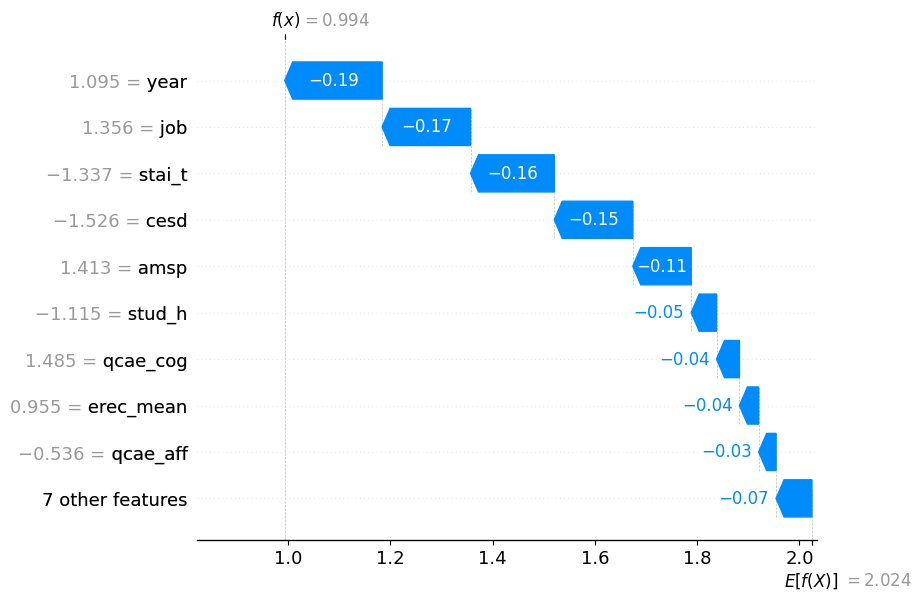

False positive


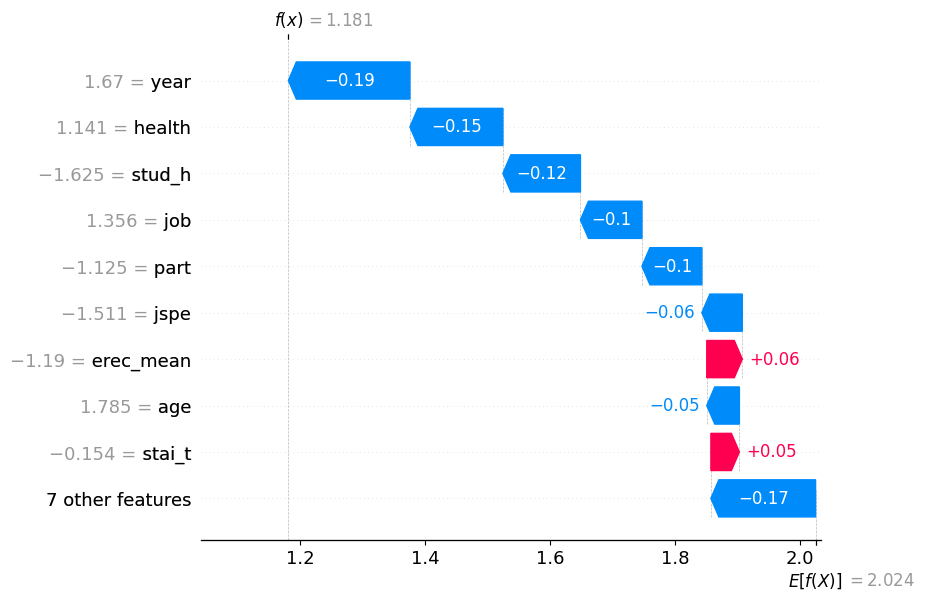

True negative


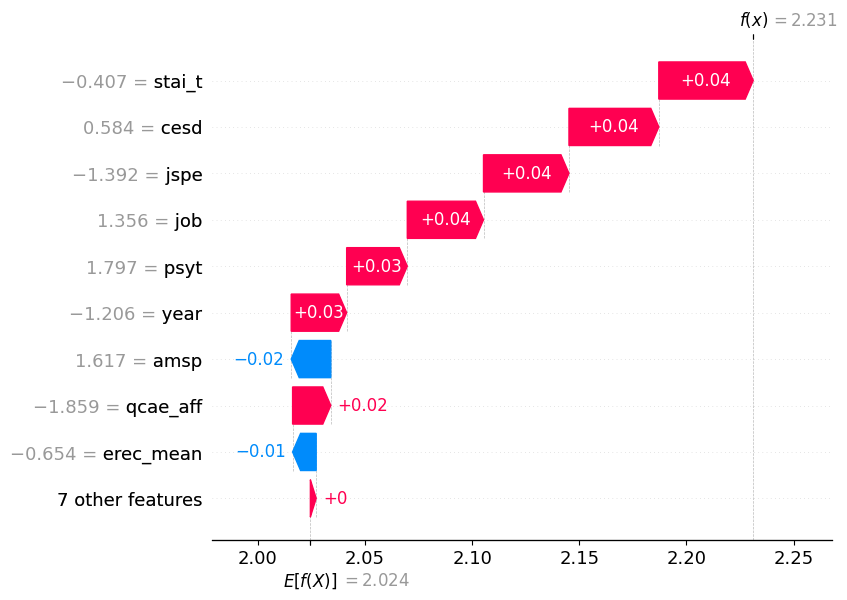

False negative


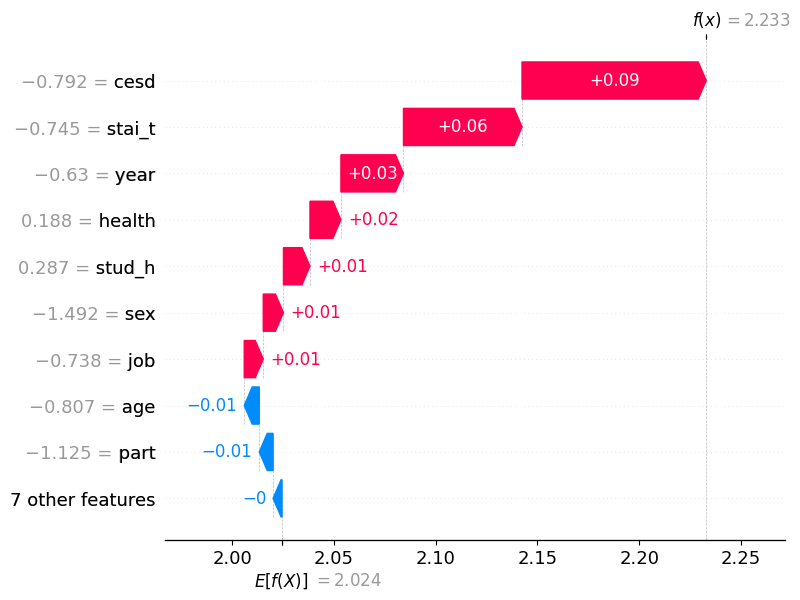

=====  mbi_cy_classes  ======
Best hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.60      1.00      0.75       100
           2       0.00      0.00      0.00        34

    accuracy                           0.60       166
   macro avg       0.20      0.33      0.25       166
weighted avg       0.36      0.60      0.45       166

Accuracy: 0.6024096385542169
Confusion Matrix:
 [[  0  32   0]
 [  0 100   0]
 [  0  34   0]]
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.60      1.00      0.75       100
           2       0.00      0.00      0.00        34

    accuracy                           0.60       166
   macro avg       0.20      0.33      0.25       166
weighted avg       0.36      0.60      0.45       166

Confusion Mat

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

no TP
no FP
True negative


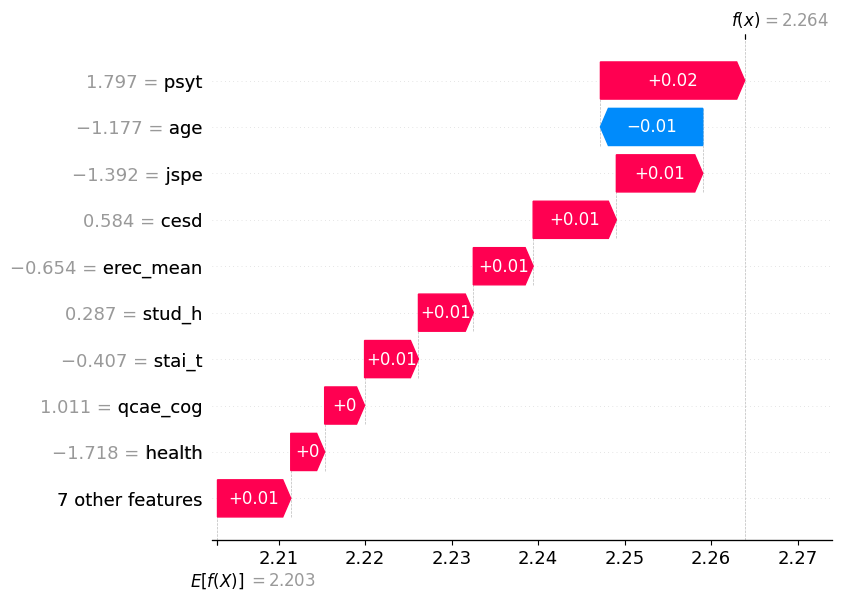

False negative


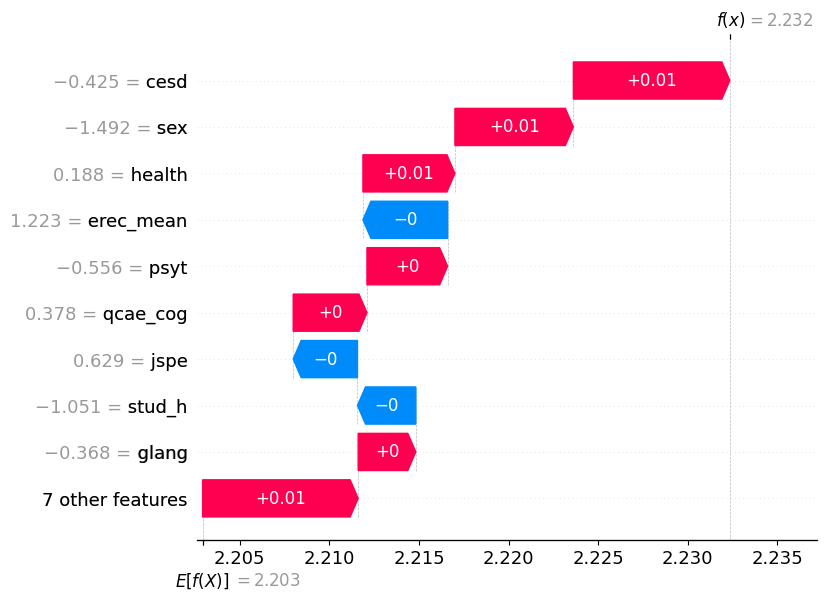

=====  mbi_ea_classes  ======
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.66      1.00      0.79       108
           2       1.00      0.07      0.12        30

    accuracy                           0.66       166
   macro avg       0.55      0.36      0.31       166
weighted avg       0.61      0.66      0.54       166

Accuracy: 0.6626506024096386
Confusion Matrix:
 [[  0  28   0]
 [  0 108   0]
 [  0  28   2]]
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.66      1.00      0.79       108
           2       1.00      0.07      0.12        30

    accuracy                           0.66       166
   macro avg       0.55      0.36      0.31       166
weighted avg       0.61      0.66      0.54       166

Confusion Ma

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

no TP
no FP
True negative


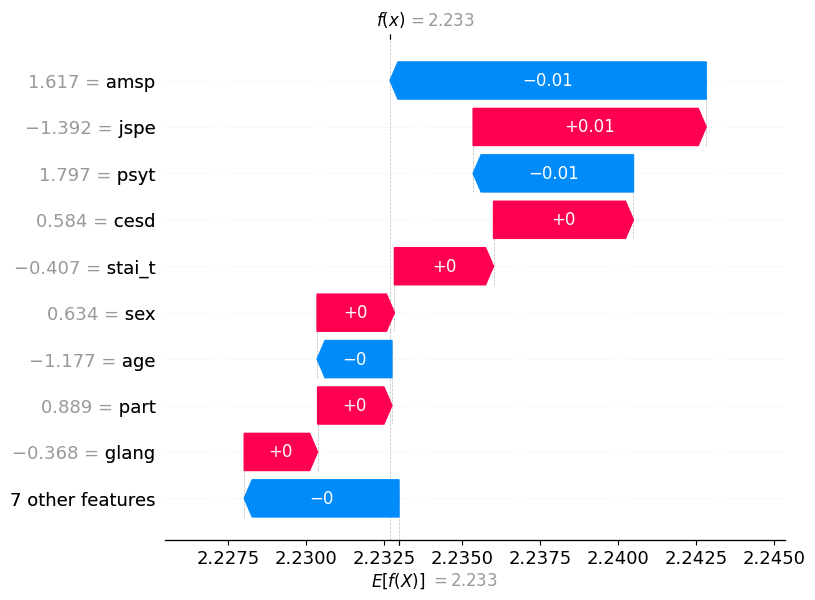

False negative


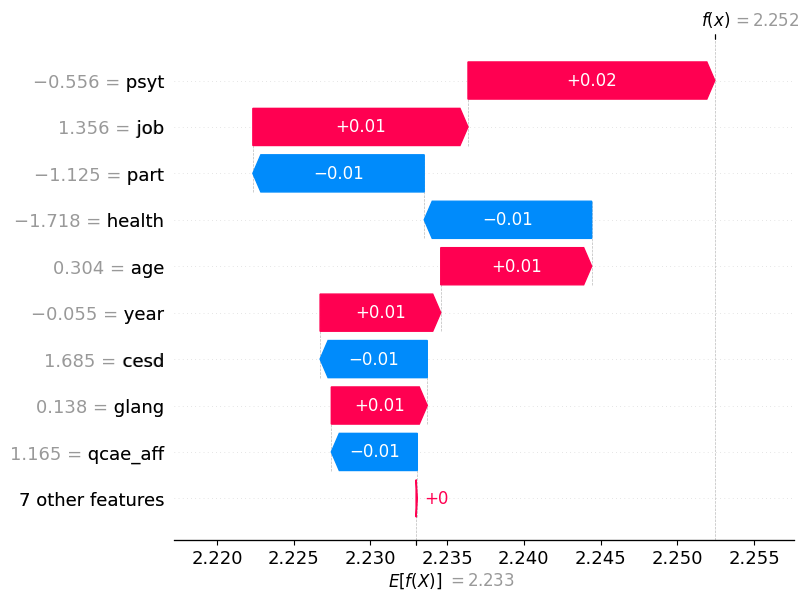

In [ ]:
# Initialize lists to store SHAP values for each classifier
shap_values_svc = {}

x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_cols)

for col in y_classes_cols:
  print(f"=====  {col}  ======")
  # Logistic Regression
  # svc = SVC(C=0.1, kernel='sigmoid', gamma='auto')
  param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
  grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
  grid_search.fit(x_train_scaled, y_train[col])
  print(f"Best hyperparameters: {grid_search.best_params_}")
  svc = grid_search.best_estimator_
  svc.fit(x_train_scaled, y_train[col])
  y_pred_log = svc.predict(x_test_scaled)
  print(classification_report(y_test[col], y_pred_log))
  acc = accuracy_score(y_test[col], y_pred_log)
  cm_rf = confusion_matrix(y_test[col], y_pred_log)
  print("Accuracy:", acc)
  print("Confusion Matrix:\n", cm_rf)


  y_test_1 = y_test[col].reset_index(drop=True)  # Reset index for easier compariso


  # Evaluation
  print("Logistic Regression Evaluation:")
  print(classification_report(y_test[col], y_pred_log))
  acc_lr_scaled.append(accuracy_score(y_test[col], y_pred_log))
  print("Confusion Matrix:\n", confusion_matrix(y_test[col], y_pred_log))

  # Explainability with SHAP for Logistic Regression
  print("\nSHAP Explainability for Logistic Regression:")
  explainer_lr = shap.Explainer(svc.decision_function, x_train_scaled)
  shap_values_svc[col] = explainer_lr(x_test_scaled)

  try:
    tp_index = y_test_1[(y_test_1 == 0) & (y_pred_log == 0)].index[0]

    print("True positive")
    shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_svc[col][tp_index].values[:, 1],
        base_values=shap_values_svc[col][tp_index].base_values[1],
        data=x_test_scaled_df.iloc[tp_index],
        feature_names=x_cols
      )
    )
  except Exception:
    print("no TP")
    pass

  try:
    # False Positive (FP)
    fp_index = y_test_1[(y_test_1 != 0) & (y_pred_log == 0)].index[0]
    print("False positive")
    shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_svc[col][fp_index].values[:, 1],
        base_values=shap_values_svc[col][fp_index].base_values[1],
        data=x_test_scaled_df.iloc[fp_index],
        feature_names=x_cols
      )
    )
  except Exception:
    print("no FP")
    pass

  try:
    tn_index = y_test_1[(y_test_1 != 0) & (y_pred_log != 0)].index[0]

    # True Negative (TN)
    print("True negative")
    shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_svc[col][tn_index].values[:, 1],
        base_values=shap_values_svc[col][tn_index].base_values[1],
        data=x_test_scaled_df.iloc[tn_index],
        feature_names=x_cols
      )
    )
  except Exception:
    print("no TN")
    pass

  try:
    fn_index = y_test_1[(y_test_1 == 0) & (y_pred_log != 0)].index[0]
    # False Negative (FN)
    print("False negative")
    shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_svc[col][fn_index].values[:, 1],
        base_values=shap_values_svc[col][fn_index].base_values[1],
        data=x_test_scaled_df.iloc[fn_index],
        feature_names=x_cols
      )
    )
  except Exception:
    print("no FN")
    pass


In [ ]:
def generate_counterfactual(model, X_input, feature_to_change, direction, step_size=0.1, max_steps=100):
    # Ensure X_input is a DataFrame
    if isinstance(X_input, np.ndarray):
        X_input = pd.DataFrame(X_input)

    entry = 0

    original_prediction = model.predict(X_input)[entry]  # Original prediction

    # Convert feature to change to index if it's given as name
    if isinstance(feature_to_change, str):
        feature_to_change = X_input.columns.get_loc(feature_to_change)

    # Initialize counterfactual as a copy of the input
    counterfactual = X_input.copy()

    # Determine the current value of the feature to change
    original_value = counterfactual.iloc[entry, feature_to_change]

    change_rate = original_value * step_size

    # Modify the feature value incrementally
    for step in range(max_steps):
        # Modify the feature
        if direction == 'increase':
            counterfactual.iloc[entry, feature_to_change] = original_value + change_rate
        elif direction == 'decrease':
            counterfactual.iloc[entry, feature_to_change] = original_value - change_rate

        # Predict with the modified instance
        new_prediction = model.predict(counterfactual)[entry]

        # If the prediction changes, stop and return the counterfactual
        if new_prediction != original_prediction:
            print(f"Prediction changed from {original_prediction} to {new_prediction} after {step+1} steps.")
            return counterfactual, new_prediction

    # If no change is detected, return the modified counterfactual
    print(f"Counterfactual generation for {feature_to_change} did not change after {max_steps * 10}% {direction}.")
    # return counterfactual, new_prediction


# Initialize lists to store SHAP values for each classifier
shap_values_lr = {}

x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_cols)
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_cols)

for col in y_classes_cols:
    print(f"=====  {col}  ======")
    param_grid = {
      'C': [0.1, 1, 10, 100],
      'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
      'gamma': ['scale', 'auto']
  }
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(x_train_scaled, y_train[col])
    print(f"Best hyperparameters: {grid_search.best_params_}")
    rf_clf = grid_search.best_estimator_
    rf_clf.fit(x_train_scaled_df, y_train[col])


    for feature in x_cols:
        print(feature)
        generate_counterfactual(rf_clf, x_test_scaled_df, feature, 'increase', step_size=0.1, max_steps=100)
        generate_counterfactual(rf_clf, x_test_scaled_df, feature, 'decrease', step_size=0.1, max_steps=100)

=====  mbi_ex_classes  ======
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
age
Counterfactual generation for 0 did not change after 1000% increase.
Counterfactual generation for 0 did not change after 1000% decrease.
year
Counterfactual generation for 1 did not change after 1000% increase.
Counterfactual generation for 1 did not change after 1000% decrease.
sex
Counterfactual generation for 2 did not change after 1000% increase.
Counterfactual generation for 2 did not change after 1000% decrease.
glang
Counterfactual generation for 3 did not change after 1000% increase.
Counterfactual generation for 3 did not change after 1000% decrease.
part
Counterfactual generation for 4 did not change after 1000% increase.
Counterfactual generation for 4 did not change after 1000% decrease.
job
Counterfactual generation for 5 did not change after 1000% increase.
Counterfactual generation for 5 did not change after 1000% decrease.
stud_h
Counterfactual generation for 6 did not c

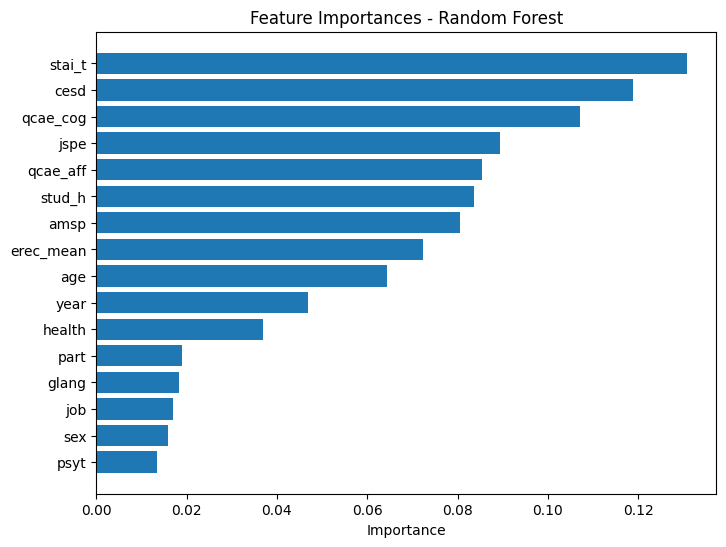

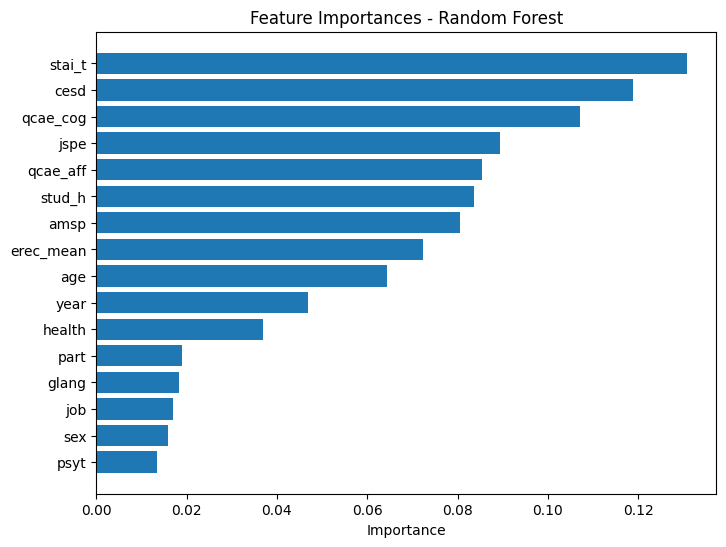

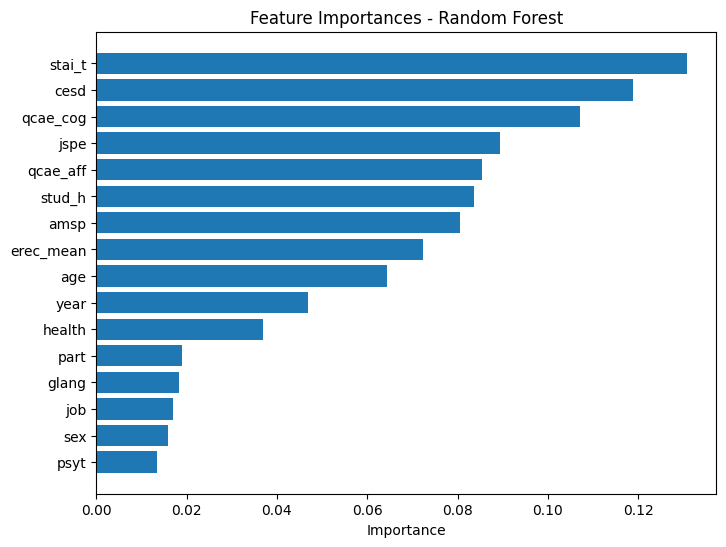

In [ ]:
for target in y_cols:
    feature_importances = rf_clf_scale.feature_importances_
    sorted_idx = np.argsort(feature_importances)

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
    plt.title(f"Feature Importances - Random Forest")
    plt.xlabel("Importance")
    plt.show()


In [ ]:
importance = np.array(x.columns)[sorted_idx]
least = 6

print(f"5 least important columns: {importance[:least]}")
x_drops = x.drop(columns=importance[:least])
x_drops.head(5)

5 least important columns: ['psyt' 'sex' 'job' 'glang' 'part' 'health']


,age,year,stud_h,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t
0,26,4,20,109,55,37,22,0.690476,7,33
1,21,3,36,106,64,39,17,0.690476,25,73
2,21,2,51,101,52,33,18,0.833333,17,48
3,21,3,22,102,58,28,21,0.690476,14,46
4,26,5,10,102,48,37,17,0.690476,14,56


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_drops, y_classes, test_size=0.2, random_state=42)

acc_lr_drops = []
acc_rf_drops = []
for col in y_classes_cols:
    print(f"=====  {col}  ======")
    # Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(x_train, y_train[col])
    y_pred_log = log_reg.predict(x_test)

    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(x_train, y_train[col])
    y_pred_rf = rf_clf.predict(x_test)

    # Evaluation
    print("Logistic Regression Evaluation:")
    print(classification_report(y_test[col], y_pred_log))
    acc = accuracy_score(y_test[col], y_pred_log)
    acc_lr_drops.append(acc)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test[col], y_pred_log))

    print("\nRandom Forest Evaluation:")
    print(classification_report(y_test[col], y_pred_rf))
    acc = accuracy_score(y_test[col], y_pred_rf)
    acc_rf_drops.append(acc)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test[col], y_pred_rf))

=====  mbi_ex_classes  ======
Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.73      0.44      0.55        25
           1       0.68      0.91      0.78       101
           2       0.69      0.28      0.39        40

    accuracy                           0.69       166
   macro avg       0.70      0.54      0.57       166
weighted avg       0.69      0.69      0.65       166

Accuracy: 0.6867469879518072
Confusion Matrix:
 [[11 14  0]
 [ 4 92  5]
 [ 0 29 11]]

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.48      0.60        25
           1       0.68      0.91      0.78       101
           2       0.56      0.23      0.32        40

    accuracy                           0.68       166
   macro avg       0.68      0.54      0.57       166
weighted avg       0.67      0.68      0.64       166

Accuracy: 0.6807228915662651
Confusion Matrix:
 [[12 12  1]
 [ 3

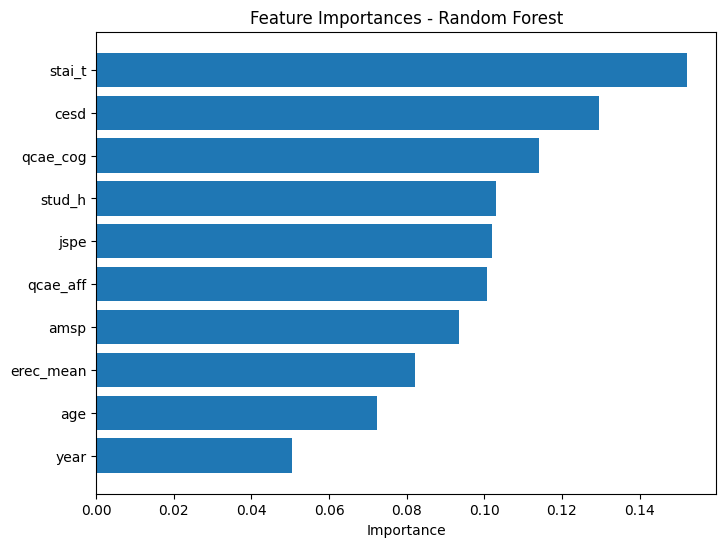

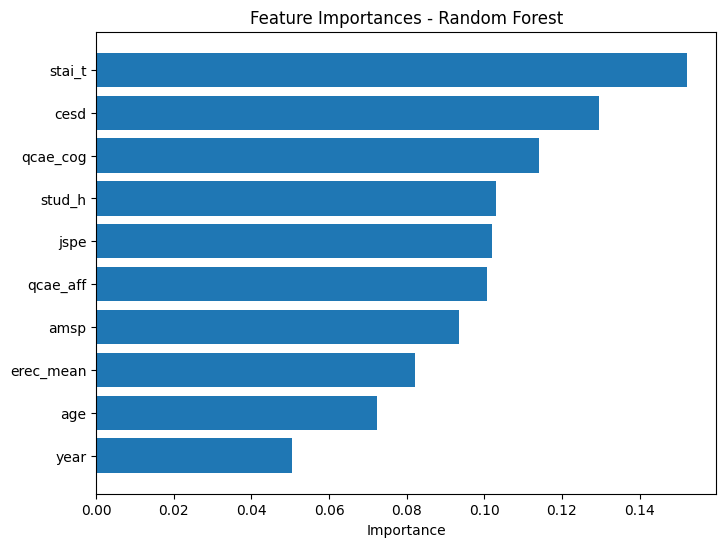

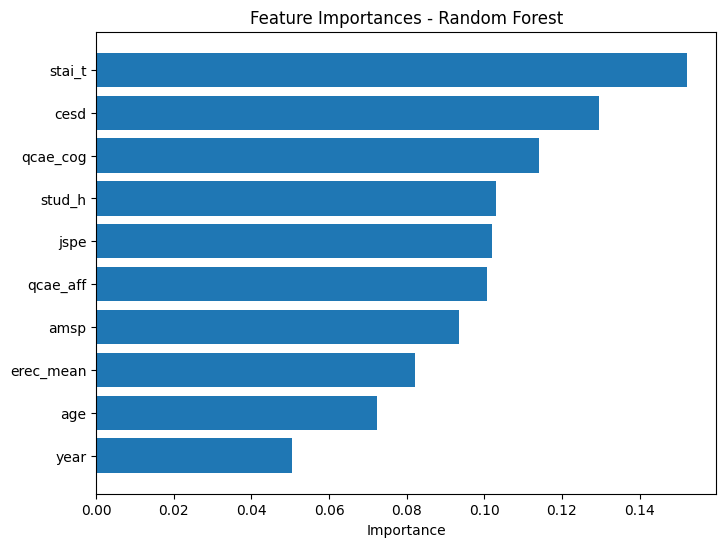

In [ ]:
for target in y_cols:
    feature_importances = rf_clf.feature_importances_
    sorted_idx = np.argsort(feature_importances)

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(x_drops.columns)[sorted_idx])
    plt.title(f"Feature Importances - Random Forest")
    plt.xlabel("Importance")
    plt.show()
